In [2]:
import os, random, json, pickle
import numpy as np
import torch
from tqdm import tqdm
from collections import Counter, defaultdict
import json

In [2]:
data_dir = "/home/yingshac/CYS/WebQnA/WebQnA_data_new/"

# Compute scores for BM25 full-scale retrieval

In [4]:
### Load val/test Retrieval_answers
split='test'
imgRetrievalAns = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/{}_imgRetrievalAns.pkl".format(split)), "rb"))
txtRetrievalAns = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/{}_txtRetrievalAns.pkl".format(split)), "rb"))

In [5]:
QimgBM25_top2_i = torch.load("result_matrix_II.pt".format(split))
QtxtBM25_top2_i = torch.load("result_matrix_TT.pt".format(split))

In [3]:
def compute_retrieval_metrics(pred, gth):
    print(f'prediction: {pred}, gth: {gth}')
    common = len(set(pred).intersection(gth))
    RE = common / (len(gth)) 
    PR = common / (len(pred)) # No protection against division by zero because it's assumed that CLIP never gives empty output
    F1 = 2*PR*RE / (PR + RE + 1e-5)
    return F1, RE, PR

In [11]:
top2_perf = [compute_retrieval_metrics(set(QimgBM25_top2_i[i].numpy()), set(imgRetrievalAns[i])) for i in range(len(imgRetrievalAns))]
print("BM25 Top2 img queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))

top2_perf = [compute_retrieval_metrics(set(QtxtBM25_top2_i[i].numpy()), set(txtRetrievalAns[i])) for i in range(len(txtRetrievalAns))]
print("BN25 Top2 txt queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))


BM25 Top2 img queries: F1=0.2019, RE=0.2574, PR=0.1742
BN25 Top2 txt queries: F1=0.3342, RE=0.3334, PR=0.3356


In [16]:
### Refer to I/T_unknown_modality_bm25.py. 
### The I_corpus was appended after T_corpus. So all img indices are shifted by 544489
imgRetrievalAns_unknownM = {}
for i in imgRetrievalAns:
    imgRetrievalAns_unknownM[i] = [j+544489 for j in imgRetrievalAns[i]]

In [6]:
QimgBM25_unknownM_top2_i = torch.load("result_matrix_Iall.pt".format(split))
QtxtBM25_unknownM_top2_i = torch.load("result_matrix_Tall.pt".format(split))

In [20]:
top2_perf = [compute_retrieval_metrics(set(QimgBM25_unknownM_top2_i[i].numpy()), set(imgRetrievalAns_unknownM[i])) for i in range(len(imgRetrievalAns_unknownM))]
print("BM25 Top2 unknownM img queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))

top2_perf = [compute_retrieval_metrics(set(QtxtBM25_unknownM_top2_i[i].numpy()), set(txtRetrievalAns[i])) for i in range(len(txtRetrievalAns))]
print("BN25 Top2 unknownM txt queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(np.mean([P[0] for P in top2_perf]), np.mean([P[1] for P in top2_perf]), np.mean([P[2] for P in top2_perf]) ))


BM25 Top2 unknownM img queries: F1=0.2043, RE=0.2597, PR=0.1767
BN25 Top2 unknownM txt queries: F1=0.2815, RE=0.2810, PR=0.2825


# BM25 Restricted Retrieval

In [4]:
dataset = json.load(open("../../WebQA_toy.json", "r"))
print(Counter([dataset[k]['split'] for k in dataset]))
print(len(set([dataset[k]['Guid'] for k in dataset])))
print(Counter([dataset[k]['Qcate'] for k in dataset]))


Counter({'train': 3387, 'val': 527})
3914
Counter({'YesNo': 1150, 'Others': 1030, 'choose': 882, 'number': 424, 'color': 325, 'shape': 103})


In [5]:
from gensim import corpora
from gensim.summarization import bm25

In [ ]:
def top_n(n):
    retricted_bm25_scores = {'Qimg': [], 'Qtxt': []}
    for g in tqdm(list(dataset.keys())):
        print(g)
        # if not dataset[g]['split'] == 'test': continue
        key = 'Qtxt' if dataset[g]['Qcate'] == 'text' else 'Qimg'
        corpus = []
        if key == 'Qtxt':
            corpus.extend([x['fact'].split() for x in dataset[g]['txt_posFacts']])
            ans = list(range(len(corpus)))
        else:
            corpus.extend([x['caption'].split() for x in dataset[g]['img_posFacts']])
            ans = list(range(len(corpus)))
        corpus.extend([x['fact'].split() for x in dataset[g]['txt_negFacts']])
        corpus.extend([x['caption'].split() for x in dataset[g]['img_negFacts']])

        dictionary = corpora.Dictionary(corpus)
        corpus = [dictionary.doc2bow(text) for text in corpus]
        bm25_obj = bm25.BM25(corpus)

        query_doc = dictionary.doc2bow(dataset[g]['Q'].replace('"', '').split())
        scores = bm25_obj.get_scores(query_doc)
        best_docs = sorted(range(len(scores)), key=lambda i: scores[i])[-n:]
        
        retricted_bm25_scores[key].append(compute_retrieval_metrics(set(best_docs), set(ans)))
    return retricted_bm25_scores

In [ ]:
import matplotlib.pyplot as plt

def diff_top_n_result():
    img_f1 = []
    img_RE = []
    img_PR = []
    for n in range(1, 2):
        retricted_bm25_scores = top_n(n)
        print(len(retricted_bm25_scores['Qimg']), len(retricted_bm25_scores['Qtxt']))
        img_f1.append(np.mean([P[0] for P in retricted_bm25_scores['Qimg']]))
        img_RE.append(np.mean([P[1] for P in retricted_bm25_scores['Qimg']]))
        img_PR.append(np.mean([P[2] for P in retricted_bm25_scores['Qimg']]))

        # print("BM25 Top{} unknownM img queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(n, np.mean([P[0] for P in retricted_bm25_scores['Qimg']]), np.mean([P[1] for P in retricted_bm25_scores['Qimg']]), np.mean([P[2] for P in retricted_bm25_scores['Qimg']]) ))
        # print("BM25 Top{} unknownM txt queries: F1={:.4f}, RE={:.4f}, PR={:.4f}".format(n, np.mean([P[0] for P in retricted_bm25_scores['Qtxt']]), np.mean([P[1] for P in retricted_bm25_scores['Qtxt']]), np.mean([P[2] for P in retricted_bm25_scores['Qtxt']]) ))
    x = list(range(1, len(img_f1) + 1))

    # Plot the lists
    plt.plot(x, img_f1, marker='o', linestyle='-', label="F1")
    plt.plot(x, img_RE, marker='s', linestyle='--', label="RE")
    plt.plot(x, img_PR, marker='d', linestyle='-.', label="PR")

    # Labels and title
    plt.xlabel("Selecting top x scores", fontsize=12)
    plt.ylabel("Results", fontsize=12)
    plt.title("Comparison of selecting different top scores", fontsize=14)

    # Add legend
    plt.legend()

    # Show the plot
    plt.grid(True)  # Optional: Adds a grid for better readability
    plt.show()
diff_top_n_result()

# Generate submission files to eval.ai to double check retrieval results

In [9]:
### Load uniid2fact
fact2uniid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/fact2uniid.pkl"), "rb"))
uniid2fact = {i:fact for fact, i in fact2uniid.items()}

# Read test_imgguid2qid, test_txtguid2qid
test_imgguid2qid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/test_imgguid2qid.pkl"), "rb"))
test_txtguid2qid = pickle.load(open(os.path.join(data_dir, "CLIP_retrieval_experiments/test_txtguid2qid.pkl"), "rb"))

In [16]:
evalai_submission_BM25_unknownM = {}
for g in dataset:
    if not dataset[g]['split'] == 'test': continue
    if dataset[g]['Qcate'] == 'text':
        retrieved_snippet_ids = []
        retrieved_facts = []
        for x in QtxtBM25_unknownM_top2_i[test_txtguid2qid[g]].tolist():
            if x < 544489: retrieved_facts.append(uniid2fact[x])
        for x in dataset[g]['txt_posFacts']:
            if x['fact'] in retrieved_facts:
                retrieved_snippet_ids.append(x['snippet_id'])
        retrieved_snippet_ids.extend((2-len(retrieved_snippet_ids))*["dummy"])
        evalai_submission_BM25_unknownM[g] = {'sources': retrieved_snippet_ids, 'answer': ""}
    else:
        evalai_submission_BM25_unknownM[g] = \
            {'sources': [ x+30000000-544489 for x in QimgBM25_unknownM_top2_i[test_imgguid2qid[g]].tolist() ], 
            'answer': ""}

json.dump(evalai_submission_BM25_unknownM, open("evalai_submission_BM25_unknownM.json", "w"))


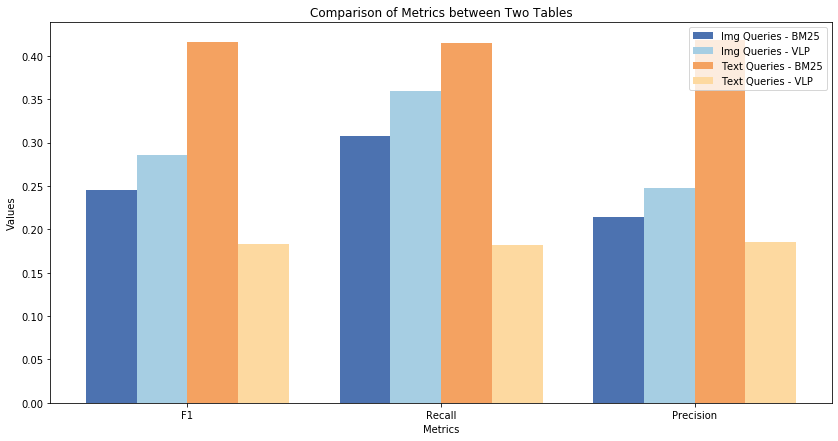

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Data from two tables
metrics = ['F1', 'Recall', 'Precision']
img_values_2 = [0.2851, 0.3598, 0.2477]  # First table (Img queries)
text_values_2 = [0.1831, 0.1817, 0.1853]  # First table (Text queries)

img_values_1 = [0.2450, 0.3080, 0.2136]  # Second table (Img queries)
text_values_1 = [0.4156, 0.4148, 0.4177]  # Second table (Text queries)

x = np.arange(len(metrics))  # X-axis positions
fig, ax = plt.subplots(figsize=(14, 7))  # Adjust size (Width x Height)
width = 0.2  # Bar width

# fig, ax = plt.subplots()
ax.bar(x - width, img_values_1, width, label='Img Queries - BM25', color='#4C72B0')
ax.bar(x, img_values_2, width, label='Img Queries - VLP', color='#A6CEE3')
ax.bar(x + width, text_values_1, width, label='Text Queries - BM25', color='#F4A261')
ax.bar(x + 2*width, text_values_2, width, label='Text Queries - VLP', color='#FDD9A0')

ax.set_xlabel("Metrics")
ax.set_ylabel("Values")
ax.set_title("Comparison of Metrics between Two Tables")
ax.set_xticks(x + width / 2)
ax.set_xticklabels(metrics)
ax.legend()
plt.show()


In [ ]:
metrics = ['F1', 'Recall', 'Precision']

# 2 times
img_values_2 = [0.3866, 0.5798, 0.2899]  
text_values_2 = [0.4180, 0.6271, 0.3136]  
# dynamic
img_values_1 = [0.3986, 0.5512, 0.3145]  
text_values_1 = [0.4447, 0.5549, 0.3712]  
# strict
img_values_1 = [0.4327, 0.4327, 0.4327]  
text_values_1 = [0.4653, 0.4653, 0.4653] 
# baseline
img_values_1 = [ 0.2450, 0.3080, 0.2136]  
text_values_1 = [0.4156, 0.4148, 0.4177] 


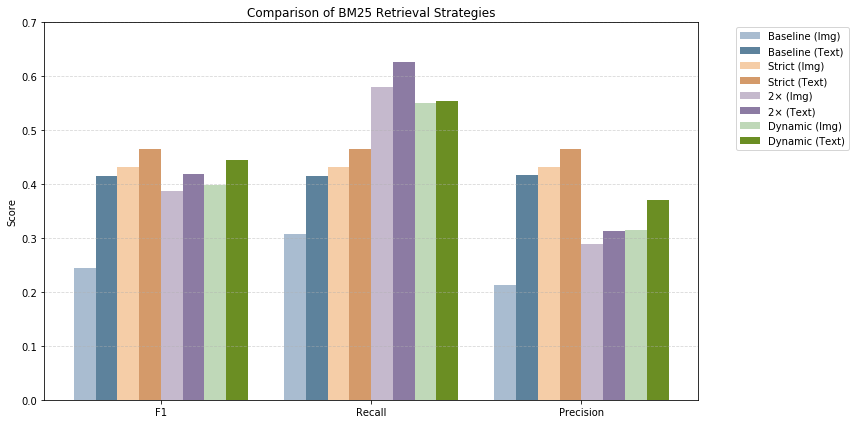

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics and setup
metrics = ['F1', 'Recall', 'Precision']
num_metrics = len(metrics)
width = 0.18
group_gap = 0.3  # space between metric groups

# Group centers for each metric
group_centers = np.arange(num_metrics) * (8 * width + group_gap)

# Define moderate color palette
colors = {
    'baseline_img': '#A9BCD0',
    'baseline_text': '#5D829C',
    'strict_img': '#F5CDA7',
    'strict_text': '#D49A6A',
    'two_x_img': '#C5B9CD',
    'two_x_text': '#8C7BA3',
    'dynamic_img': '#BFD8B8',
    'dynamic_text': '#6B8E23'
}

# Values for each setup (image and text)
baseline_img = [0.2450, 0.3080, 0.2136]
baseline_text = [0.4156, 0.4148, 0.4177]
strict_img = [0.4327, 0.4327, 0.4327]
strict_text = [0.4653, 0.4653, 0.4653]
two_x_img = [0.3866, 0.5798, 0.2899]
two_x_text = [0.4180, 0.6271, 0.3136]
dynamic_img = [0.3986, 0.5512, 0.3145]
dynamic_text = [0.4447, 0.5549, 0.3712]

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

for i in range(num_metrics):
    base = group_centers[i]
    
    ax.bar(base - 3.5*width, baseline_img[i], width, color=colors['baseline_img'])
    ax.bar(base - 2.5*width, baseline_text[i], width, color=colors['baseline_text'])

    ax.bar(base - 1.5*width, strict_img[i], width, color=colors['strict_img'])
    ax.bar(base - 0.5*width, strict_text[i], width, color=colors['strict_text'])

    ax.bar(base + 0.5*width, two_x_img[i], width, color=colors['two_x_img'])
    ax.bar(base + 1.5*width, two_x_text[i], width, color=colors['two_x_text'])

    ax.bar(base + 2.5*width, dynamic_img[i], width, color=colors['dynamic_img'])
    ax.bar(base + 3.5*width, dynamic_text[i], width, color=colors['dynamic_text'])

# Set labels and formatting
ax.set_ylabel('Score')
ax.set_title('Comparison of BM25 Retrieval Strategies')
ax.set_xticks(group_centers)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 0.7)
ax.grid(axis='y', linestyle='--', alpha=0.5)

ax.legend([
    'Baseline (Img)', 'Baseline (Text)',
    'Strict (Img)', 'Strict (Text)',
    '2× (Img)', '2× (Text)',
    'Dynamic (Img)', 'Dynamic (Text)'
], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [3]:
import json

# Load original JSON
with open("test_retrieved_contexts_strict.json", "r") as f:
    data = json.load(f)

# Reformatting logic
reformatted = {}

for guid, content in data.items():
    sources = []
    for ctx in content.get("Retrieved Contexts", []):
        if "image_id" in ctx:
            sources.append(str(ctx["image_id"]))
        elif "snippet_id" in ctx:
            sources.append(ctx["snippet_id"])
    
    answer = content.get("Answer", [""])[0]
    reformatted[guid] = {
        "sources": sources,
        "answer": answer
    }

# Save to new JSON
with open("test__strict_reformatted.json", "w") as f:
    json.dump(reformatted, f, indent=2)


In [1]:
# Define metrics and values
metrics = ['F1', 'Recall', 'Precision']

baseline_img = [0.2450, 0.3080, 0.2136]
strict_img = [0.4327, 0.4327, 0.4327]
two_x_img = [0.3866, 0.5798, 0.2899]
dynamic_img = [0.3986, 0.5512, 0.3145]

baseline_text = [0.4156, 0.4148, 0.4177]
strict_text = [0.4653, 0.4653, 0.4653]
two_x_text = [0.4180, 0.6271, 0.3136]
dynamic_text = [0.4447, 0.5549, 0.3712]

def percentage_increase(new, baseline):
    return [(n - b) / b * 100 for n, b in zip(new, baseline)]

# Calculate increases
methods_img = {
    'Strict (Img)': percentage_increase(strict_img, baseline_img),
    '2x (Img)': percentage_increase(two_x_img, baseline_img),
    'Dynamic (Img)': percentage_increase(dynamic_img, baseline_img),
}

methods_text = {
    'Strict (Text)': percentage_increase(strict_text, baseline_text),
    '2x (Text)': percentage_increase(two_x_text, baseline_text),
    'Dynamic (Text)': percentage_increase(dynamic_text, baseline_text),
}

# Display results
print("🔹 Percentage Increase Over Baseline (Image)")
for method, increases in methods_img.items():
    print(f"{method}:")
    for metric, value in zip(metrics, increases):
        print(f"  {metric}: {value:.2f}%")
    print()

print("🔹 Percentage Increase Over Baseline (Text)")
for method, increases in methods_text.items():
    print(f"{method}:")
    for metric, value in zip(metrics, increases):
        print(f"  {metric}: {value:.2f}%")
    print()


🔹 Percentage Increase Over Baseline (Image)
Strict (Img):
  F1: 76.61%
  Recall: 40.49%
  Precision: 102.57%

2x (Img):
  F1: 57.80%
  Recall: 88.25%
  Precision: 35.72%

Dynamic (Img):
  F1: 62.69%
  Recall: 78.96%
  Precision: 47.24%

🔹 Percentage Increase Over Baseline (Text)
Strict (Text):
  F1: 11.96%
  Recall: 12.17%
  Precision: 11.40%

2x (Text):
  F1: 0.58%
  Recall: 51.18%
  Precision: -24.92%

Dynamic (Text):
  F1: 7.00%
  Recall: 33.78%
  Precision: -11.13%

